Oriya Villarreal

Homework 7

17 November 2022

---

**Problem 1: ENSO Phases**

A. Following Lab 7-1 and Lab 7-2, A) Use the time series of the phase of the El Niño Southern Oscillation (ENSO) from 1900-2022 to create a lag-1 Markov model of the ENSO phase. where the observed Phases of ENSO are as follows:

1: warm (El Niño) 

2: neutral (ENSO neutral) 

3: cool, (La Niña)

In [1]:
import numpy as np
from scipy.linalg import eig
import scipy.stats as stats
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
df = pd.read_csv('ENSO_to2022.csv', comment='#')
df.head(3)

,Water Year,ENSO Phase,Unnamed: 2
0,1900,1,NaN
1,1901,2,NaN
2,1902,2,NaN


In [3]:
# first, read in data that Jessica generated (sequence of states 1, 2, 3, and 4):
data = np.genfromtxt('markov_random.txt',dtype=int)

In [4]:
# This counts the transitions from each state to the next and marks that count
S = sparse.csr_matrix((np.ones_like(data[:-1]), (data[:-1], data[1:])), dtype=float)

# This converts those counts to matrix form
tm = S.todense()
print(tm)

[[ 0.  0.  0.  0.  0.]
 [ 0. 16. 53. 22. 28.]
 [ 0. 31. 34. 12. 56.]
 [ 0. 13. 34. 48. 28.]
 [ 0. 58. 12. 41. 13.]]


Normalize the transition matrix to get probabilities. This will create our lag-1 Markov Model.

In [5]:
tm_norm = tm / tm.sum(axis=1)
    
print(tm_norm) # This is our normalized transition matrix.

[[       nan        nan        nan        nan        nan]
 [0.         0.13445378 0.44537815 0.18487395 0.23529412]
 [0.         0.23308271 0.2556391  0.09022556 0.42105263]
 [0.         0.10569106 0.27642276 0.3902439  0.22764228]
 [0.         0.46774194 0.09677419 0.33064516 0.10483871]]


/tmp/ipykernel_166/1530669974.py:1: RuntimeWarning: invalid value encountered in true_divide
  tm_norm = tm / tm.sum(axis=1)


Compute cumulative sums along the rows, make sure these sum to 1. (We will use this cdf matrix below in a simulation of ENSO phases)

In [6]:
# We take the above probabilities of transitions, and turn them into discrete CDF's.
# These will allow us to map random numbers generated from a uniform distribution into 
# transitions that follow these probability rules.
tm_cdf = np.cumsum(tm_norm,1)

---
**B.** Using this Markov model and a random number generator, simulate 5,000 years of ENSO data.

In [7]:
n_years = 5000
q = np.random.uniform(0,1,n_years); # uniformly distributed random numbers n_years long

initialstate = 2; # give it an initial state, doesn't really matter which

Nrand = np.zeros_like(q) # initialize an array of the proper size, with the initial state
Nrand[0] = initialstate;

# Now, just like we did when we created monte carlo simulations from empirical CDFs,
# we use our uniform random numbers to look up the next state in the transition matrix
for i in range(1,n_years):
    if q[i] <= tm_cdf[int(Nrand[i-1]),1]: #probability of transitioning from state i to 1
        Nrand[i] = 1;
    elif q[i] <= tm_cdf[int(Nrand[i-1]),2]: #transition from state i to 2
        Nrand[i] = 2;
        
    else: 
        Nrand[i] = 3;

---
**C.** Using this randomly generated data, answer the following questions. 

1 According to the model, what is the probability that three warm ENSO years would occur in a row?

2 What is the large-sample probability that three cool ENSO years would happen in a row?

(Try refreshing the numbers several times to increase the sample size if the condition never happens.) 

In [8]:
# Answer to 1: probability that three warm ENSO years would occur in a row
Warm = [Nrand[0:-2], Nrand[1:-1], Nrand[2:]] # stack our data 3 times, shifting it to the right by 1 each time
Warm = np.stack(Warm, axis=1)

G2 = np.where((np.max(Warm, axis=1) == 3) & (np.min(Warm, axis=1) == 3))
# if both the maximum and the minimum are 3, then we have 4 threes in our sequence

frequencyof3ones = G2[0].size / Warm.shape[0]

print('Frequency of three warm ENSO years in a row = {}%'.format(100*np.round(frequencyof3ones,3)))

Frequency of three warm ENSO years in a row = 21.9%


In [9]:
# Answer to 2: large-sample probability that three cool ENSO years would happen in a row

Cool = [Nrand[0:-3], Nrand[1:-2], Nrand[2:-1], Nrand[3:]] # stack our data 4 times, shifting it to the right by 1 each time
Cool = np.stack(Cool, axis=1)

G2 = np.where((np.max(Cool, axis=1) == 3) & (np.min(Cool, axis=1) == 3))
# if both the maximum and the minimum are 3, then we have 4 threes in our sequence

frequencyof3cool = G2[0].size / Cool.shape[0]

print('Frequency of three cool ENSO years in a row = {}%'.format(100*np.round(frequencyof3cool,3)))

Frequency of three cool ENSO years in a row = 13.600000000000001%


---

**Problem 2: Rating Curves and Application of Bayes Theorem with MCMC**

In [10]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.io as sio 

%matplotlib inline
sio.loadmat?

Signature: sio.loadmat(file_name, mdict=None, appendmat=True, **kwargs)
Docstring:
Load MATLAB file.

Parameters
----------
file_name : str
   Name of the mat file (do not need .mat extension if
   appendmat==True). Can also pass open file-like object.
mdict : dict, optional
    Dictionary in which to insert matfile variables.
appendmat : bool, optional
   True to append the .mat extension to the end of the given
   filename, if not already present.
byte_order : str or None, optional
   None by default, implying byte order guessed from mat
   file. Otherwise can be one of ('native', '=', 'little', '<',
   'BIG', '>').
mat_dtype : bool, optional
   If True, return arrays in same dtype as would be loaded into
   MATLAB (instead of the dtype with which they are saved).
squeeze_me : bool, optional
   Whether to squeeze unit matrix dimensions or not.
chars_as_strings : bool, optional
   Whether to convert char arrays to string arrays.
matlab_compatible : bool, optional
   Returns matrices a

In [11]:
data = sio.loadmat('Lyell_h_Q_sorted.mat')

In [12]:
type(data)

dict

In [13]:
df = pd.DataFrame(np.hstack((data['date_of_obs'], data['h1'], data['Qobs1'])),
                  columns=['date_of_obs','h1', 'Qobs1'])
df.head()

,date_of_obs,h1,Qobs1
0,[9/26/08 16:30],0.1805,0.07786
1,[9/19/08 0:02],0.2197,0.071914
2,[9/10/08 21:35],0.2406,0.143829
3,[9/10/10 17:52],0.2407,0.168177
4,[8/20/07 18:22],0.2565,0.243489


In [14]:
df['date_of_obs'] = [pd.to_datetime(dt[0], format='%m/%d/%y %H:%M') for dt in df['date_of_obs']]
df.head()

,date_of_obs,h1,Qobs1
0,2008-09-26 16:30:00,0.1805,0.07786
1,2008-09-19 00:02:00,0.2197,0.071914
2,2008-09-10 21:35:00,0.2406,0.143829
3,2010-09-10 17:52:00,0.2407,0.168177
4,2007-08-20 18:22:00,0.2565,0.243489


In [15]:
# Define a level where the transition occurs, where you need different rating curve coefficients.
h11 = 0.59
Qobs_now = df.Qobs1[df.h1 > h11]
h_now = df.h1[df.h1 > h11]

In [16]:
b=0.28
# and we subtract this value off of the measured stream height
hobs_minusb=h_now.subtract(b)
print(hobs_minusb)

36    0.3296
37    0.3344
38    0.3558
39    0.3572
40    0.3637
41     0.364
42     0.393
43    0.3953
44    0.3957
45    0.4025
46    0.4073
47     0.416
48     0.416
49    0.4261
50     0.432
51     0.444
52    0.4569
53    0.4643
54     0.465
55    0.4857
56     0.504
57    0.5068
58    0.5342
59    0.5414
60     0.556
61    0.5697
62    0.5715
63    0.6554
64    0.6685
65    0.6691
66    0.6703
67     0.687
68    0.6881
69    0.6952
70    0.7049
71     0.709
72     0.714
73    0.8006
74    0.8274
75     0.829
76     0.829
77    0.8334
78    0.8481
Name: h1, dtype: object


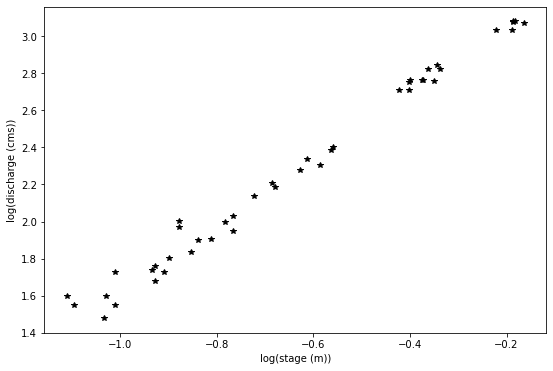

In [17]:
#And plot the log transform of both variables
loght=np.log(hobs_minusb.astype('float'))
# note that the above is taking the log of the observed values minus b
logQ=np.log(Qobs_now.astype('float'))

plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')

In [18]:
x=loght
# Note that our x value here includes the log of our measured stage minus b (see above)
y=logQ
n = len(x)

B1 = ( n*np.sum(x*y) - np.sum(x)*np.sum(y) ) / ( n*np.sum(x**2) - np.sum(x)**2 ) # B1 parameter, slope
B0 = np.mean(y) - B1*np.mean(x) # B0 parameter, y-intercept

print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))

B0 : 3.4077
B1 : 1.7662


In [19]:
# Find 95% confidence intervals 
# borrowing from Lab 4.3
B0 = np.mean(y) - B1*np.mean(x)
y_predicted = B0 + B1*x
residuals = (y - y_predicted)

# sum of squared errors
sse = np.sum(residuals**2)

# standard error of regression
s = np.sqrt(sse/(n-2))

# create an array of x values
p_x = np.linspace(x.min(),x.max(),100)

# using our model parameters to predict y values
p_y = B0 + B1*p_x

# calculate the standard error of the predictions
sigma_ep = np.sqrt( s**2 * (1 + 1/n + ( ( n*(p_x-x.mean())**2 ) / ( n*np.sum(x**2) - np.sum(x)**2 ) ) ) )

# our chosen alpha
alpha = 0.05

# compute our degrees of freedom with the length of the predicted dataset
n = len(p_x)
dof = n - 2

# get the t-value for our alpha and degrees of freedom
t = st.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits at each of the p_x values
p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep

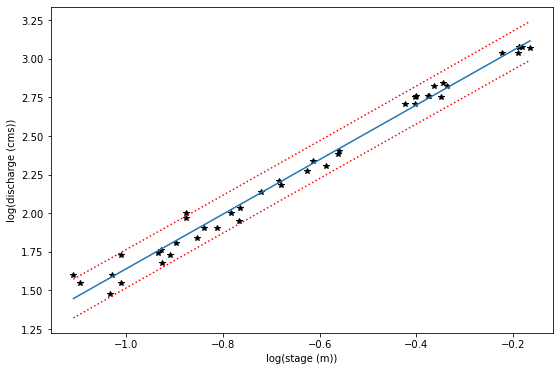

In [20]:
# make a plot in the log-transformed space
plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')
plt.plot(p_x,p_y)
plt.plot(p_x,p_y_lower,':r')
plt.plot(p_x,p_y_upper,':r')

A. Least squares linear regression fitting (with transformed variables) using b = 0.28 m

Text(0.5, 1.0, 'Best estimate with 95% confidence intervals')

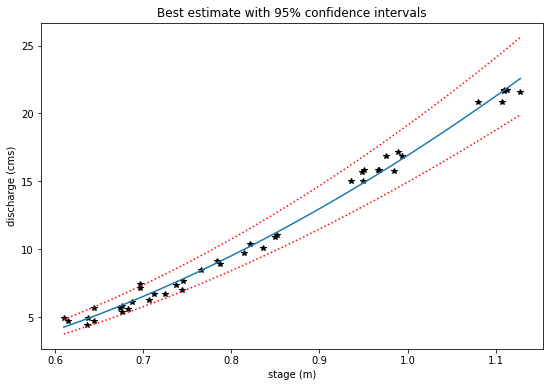

In [21]:
# Now we transform each piece back into the original form
Q_predict=np.exp(p_y)
Q_predict_upper=np.exp(p_y_upper)
Q_predict_lower=np.exp(p_y_lower)
x_topredict=np.exp(p_x) + b

# Plot the original data and then the prediction lines
plt.figure(figsize=(9,6))

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'k*')
plt.plot(x_topredict,Q_predict)
plt.plot(x_topredict,Q_predict_lower,':r')
plt.plot(x_topredict,Q_predict_upper,':r')


plt.title('Best estimate with 95% confidence intervals')

B1. If b = 0.10

In [22]:
b=0.10
hobs_minusb=h_now.subtract(b)

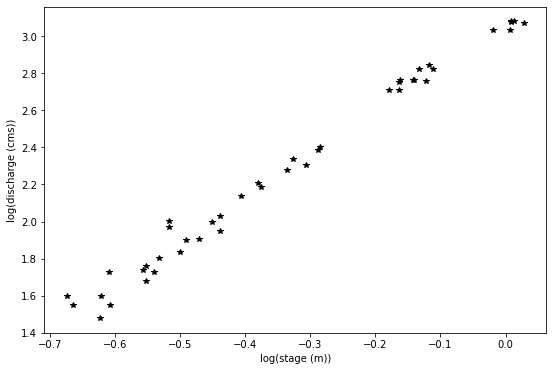

In [23]:
# plot the log transform of both variables
loght=np.log(hobs_minusb.astype('float'))

# note that the above is taking the log of the observed values minus b
logQ=np.log(Qobs_now.astype('float'))

plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')

In [24]:
x=loght
# Note that our x value here includes the log of our measured stage minus b (see above)
y=logQ
n = len(x)

B1 = ( n*np.sum(x*y) - np.sum(x)*np.sum(y) ) / ( n*np.sum(x**2) - np.sum(x)**2 ) # B1 parameter, slope
B0 = np.mean(y) - B1*np.mean(x) # B0 parameter, y-intercept

print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))

B0 : 3.0771
B1 : 2.3636


2B. if b = 0.20

In [25]:
b=0.20
hobs_minusb=h_now.subtract(b)

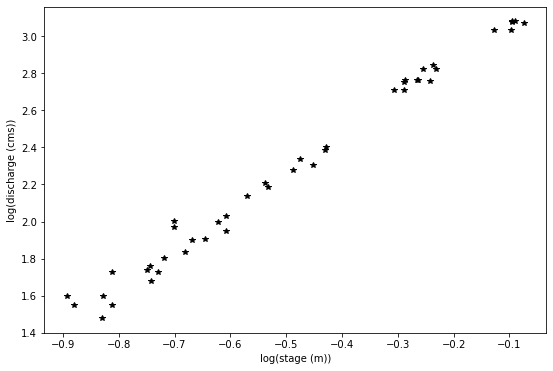

In [26]:
# plot the log transform of both variables
loght=np.log(hobs_minusb.astype('float'))

# note that the above is taking the log of the observed values minus b
logQ=np.log(Qobs_now.astype('float'))

plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')

In [27]:
x=loght
# Note that our x value here includes the log of our measured stage minus b (see above)
y=logQ
n = len(x)

B1 = ( n*np.sum(x*y) - np.sum(x)*np.sum(y) ) / ( n*np.sum(x**2) - np.sum(x)**2 ) # B1 parameter, slope
B0 = np.mean(y) - B1*np.mean(x) # B0 parameter, y-intercept

print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))

B0 : 3.2819
B1 : 2.0337


3B. if b = 0.30

In [28]:
b=0.30
hobs_minusb=h_now.subtract(b)

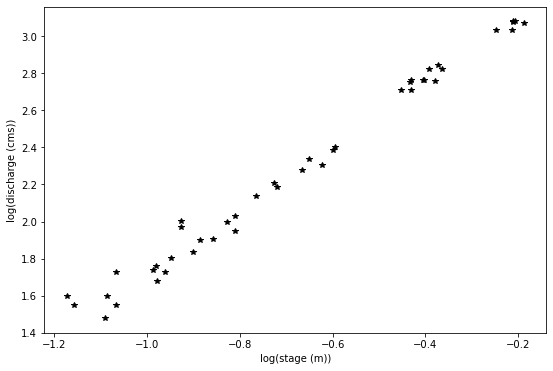

In [29]:
# plot the log transform of both variables
loght=np.log(hobs_minusb.astype('float'))

# note that the above is taking the log of the observed values minus b
logQ=np.log(Qobs_now.astype('float'))

plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')

In [30]:
x=loght
# Note that our x value here includes the log of our measured stage minus b (see above)
y=logQ
n = len(x)

B1 = ( n*np.sum(x*y) - np.sum(x)*np.sum(y) ) / ( n*np.sum(x**2) - np.sum(x)**2 ) # B1 parameter, slope
B0 = np.mean(y) - B1*np.mean(x) # B0 parameter, y-intercept

print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))

B0 : 3.433
B1 : 1.6986


4. if b= 0.40


In [31]:
b=0.40
hobs_minusb=h_now.subtract(b)

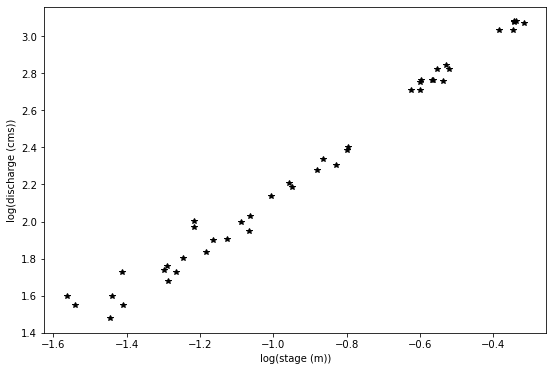

In [32]:
# plot the log transform of both variables
loght=np.log(hobs_minusb.astype('float'))

# note that the above is taking the log of the observed values minus b
logQ=np.log(Qobs_now.astype('float'))

plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')

In [33]:
x=loght
# Note that our x value here includes the log of our measured stage minus b (see above)
y=logQ
n = len(x)

B1 = ( n*np.sum(x*y) - np.sum(x)*np.sum(y) ) / ( n*np.sum(x**2) - np.sum(x)**2 ) # B1 parameter, slope
B0 = np.mean(y) - B1*np.mean(x) # B0 parameter, y-intercept

print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))

B0 : 3.5154
B1 : 1.3537


5. if b=0.50

In [34]:
b=0.50
hobs_minusb=h_now.subtract(b)

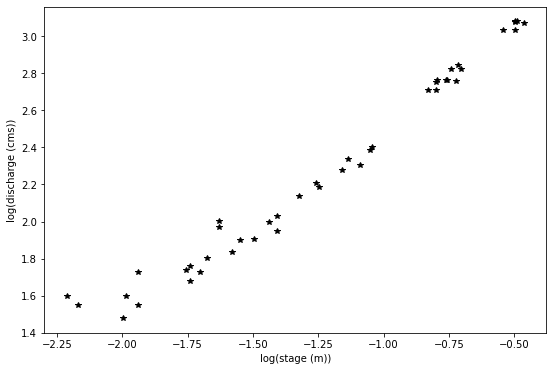

In [35]:
# plot the log transform of both variables
loght=np.log(hobs_minusb.astype('float'))

# note that the above is taking the log of the observed values minus b
logQ=np.log(Qobs_now.astype('float'))

plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')

In [36]:
x=loght
# Note that our x value here includes the log of our measured stage minus b (see above)
y=logQ
n = len(x)

B1 = ( n*np.sum(x*y) - np.sum(x)*np.sum(y) ) / ( n*np.sum(x**2) - np.sum(x)**2 ) # B1 parameter, slope
B0 = np.mean(y) - B1*np.mean(x) # B0 parameter, y-intercept

print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))

B0 : 3.496
B1 : 0.9861


For b=0.28: B0 : 3.4077, B1 : 1.7662

1. For b=0.1: B0 : 3.0771, B1 : 2.3636
2. For b=0.2: B0 : 3.2819, B1 : 2.0337
3. For b=0.3: B0 : 3.433, B1 : 1.6986
4. For b=0.4: B0 : 3.5154, B1 : 1.3537
5. For b= 0.5: B0 : 3.496, B1 : 0.9861

Range for B1 = 1.3775 < 1.7662

Range for B0 = 0.4383



Analysis: The value for our y-intercept increases as our b value increases for 0.1 < b < 0.5. The value for the slope decreases as the value of b increases. B0 and B1 are inversely related for this dataset and model. 

**C.** Using the code in Lab 7-3, create plots and discuss the differences in the results from these three methods (Least squares linear regression, Direct monte carlo parameter estimation Bayesian MCMC fitting)

In [37]:
b0 = 0.2833
a0 = 25
c0 = 1.66 # and this one I won't vary

In [38]:
Qest0 = a0 * (h_now-b0)**c0
SSE0 = np.sum((Qest0-Qobs_now)**2)
SSE0

158.11032268871054

In [39]:
# So, I set my limits of my uniform distribution
amin = 5
amax = 50
bmin = 0.15
bmax = 0.45

# for first step, I know I picked values in with the range, so 
P0 = 1

In [40]:
Lmc = 10000 #number of steps to run MCMC routine for.
burn_in = 1000 #estimate the number of steps before Markov Chain becomes stationary
# basically, the burn-in steps will not be used in calculating final probabilities because 
# they depend on the initial parameter estimates.

# Initialize arrays to store results in
PthetaQ = np.ones((Lmc,1))
amc = np.zeros((Lmc,1))
bmc = np.zeros((Lmc,1))

In [41]:
PthetaQ[0] = SSE0*P0 # this is our starting point.
    # Note that this calculation is not a true probability of P(theta|Q) but a relative metric
amc[0] = a0
bmc[0] = b0
# We save all the values at each step.

In [42]:
for imc in range(1,Lmc):
    
        # first we jump in a
    newjumpa = amc[imc-1] + (amax-amin)/(10*np.random.normal())
    
        # Now we repeat with a jump in b, assuming it's totally independent of a
        # and require both to be within their uniform distributions. 
        
    newjumpb = bmc[imc-1] + (bmax-bmin)/(10*np.random.normal())
    
    if (newjumpa >= amin) and (newjumpa <= amax) and (newjumpb >= bmin) and (newjumpb <= bmax):
        #then the prior is okay, and we can proceed 
        # (Note that prior makes any choice outside of our set range impossible)
        Qest1 = newjumpa*(h_now-newjumpb)**c0
        
        # calculate how well the parameters at our new location lead to a model that matches the data
        SSE1=np.sum((Qest1-Qobs_now)**2)
        
        # posterior is SSE1*1 (because we're within the prior uniform domain)
        # the if statement essentially says everything else is multiplied by 0
        
        if SSE1 < PthetaQ[imc-1]:
            # then the error is less, and we found a better place, and we update a and b
            amc[imc] = newjumpa
            bmc[imc] = newjumpb
            PthetaQ[imc] = SSE1 # this becomes the one to beat
        else:
            jumpscore = PthetaQ[imc-1]/SSE1 # this gives a number between 0 and 1
            
            # This is essentially a rating of how much worse this new location is than 
            # where you are right now.  The sum of squared errors is larger, but by how much
            
            # Generate random number from 0 to 1, so that we will jump with a probability of 
            # the jumpscore
            # if our new SSE is 90% as good as our current one, we jump there 90% of the time; 
            # if it's 10% as good, we jump there 10% of the time
            if np.random.uniform() <= jumpscore:
                # then we go there
                amc[imc] = newjumpa
                bmc[imc] = newjumpb
                PthetaQ[imc] = SSE1 # this becomes the one to beat
            else:
                amc[imc]=amc[imc-1]
                bmc[imc]=bmc[imc-1]
                PthetaQ[imc]=PthetaQ[imc-1] # we stay where we are for another timestep

    else:
    # you are outside of the bounds of the uniform prior, so posterior would be 0 and we don't go there
        amc[imc]=amc[imc-1]
        bmc[imc]=bmc[imc-1]
        PthetaQ[imc]=PthetaQ[imc-1] # we stay where we are

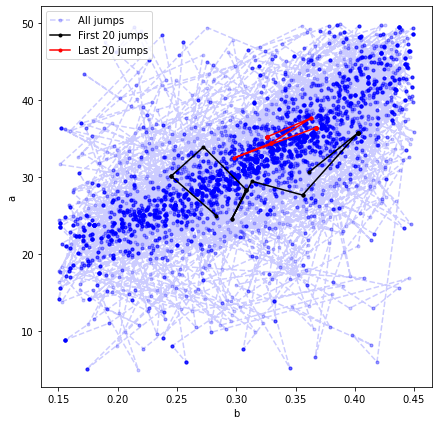

In [43]:
# Visualize all jumps across the a vs b parameter space
plt.figure(figsize=(7,7))
plt.plot(bmc,amc,'b.--',alpha=0.2,label='All jumps')
# Visualize the first 20 jumps
plt.plot(bmc[:20],amc[:20],'k.-',alpha=1,label='First 20 jumps')
# Visualize the last 20 jumps
plt.plot(bmc[-20:],amc[-20:],'r.-',alpha=1,label='Last 20 jumps')
plt.xlabel('b')
plt.ylabel('a')
plt.legend();

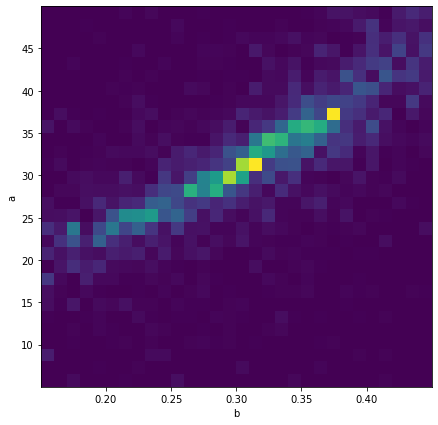

In [44]:
# "Heatmap" of all jumps across the a vs b parameter space
plt.figure(figsize=(7,7))
plt.hist2d(bmc.ravel(),amc.ravel(),30);
plt.xlabel('b')
plt.ylabel('a');

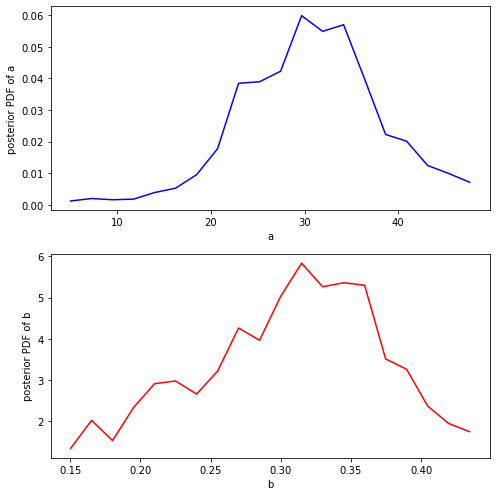

In [45]:
# What are the marginal PDFs for a and b?
a = plt.hist(amc[burn_in:],20);
b = plt.hist(bmc[burn_in:],20);
plt.close();

f, ax = plt.subplots(2,1,figsize=(7,7))
# A
ax[0].plot(a[1][:-1],a[0]/(np.sum(a[0])*(a[1][1]-a[1][0])),'b')
ax[0].set_xlabel('a')
ax[0].set_ylabel('posterior PDF of a')
# B
ax[1].plot(b[1][:-1],b[0]/(np.sum(b[0])*(b[1][1]-b[1][0])),'r')
ax[1].set_xlabel('b')
ax[1].set_ylabel('posterior PDF of b')
f.tight_layout()

95% confidence intervals for the predicted Q:

In [46]:
# evenly space 25 stage values (could have more if doesn't look smooth)
hh=np.linspace(0.54,1.5,25) 

# Make an empirical CDF for all calculated values of Q using a and b after the burn-in time 
# and plot the median and 95% confidence values from the Markov Chain generated probabilities
NN=amc[burn_in:].size

In [47]:
Q025 = np.ones((hh.shape))
Q50 = np.ones((hh.shape))
Q975 = np.ones((hh.shape))

for ih in range (hh.size):
    Qhh = amc[burn_in:]*(hh[ih]-bmc[burn_in:])**c0
    xsort = np.sort(Qhh[:,0])
    ranks = np.array(range(NN))+1
    x_CDF = 1 - (ranks - 0.4)/(NN + 0.2)
    
    Q025[ih] = np.interp(0.025,1-x_CDF,xsort)
    Q975[ih] = np.interp(0.975,1-x_CDF,xsort)
    Q50[ih] = np.interp(0.5,1-x_CDF,xsort)

Plot the median and 95% confidence values from the Markov Chain generated probabilities

Text(0.5, 1.0, 'Best estimate with 95% confidence intervals')

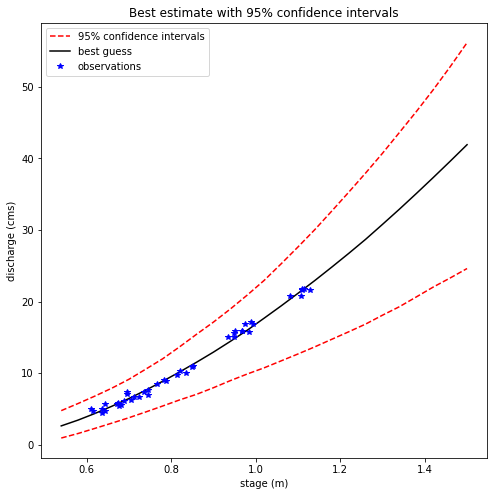

In [49]:
plt.figure(figsize=(8,8))
plt.plot(hh,Q025,'r--',label='95% confidence intervals')

plt.plot(hh,Q975,'r--')
plt.plot(hh,Q50,'k-',label='best guess')
plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'b*',label='observations')
plt.legend()
plt.title('Best estimate with 95% confidence intervals')

Analysis between all plots in this HW Set: 

The least squared linear regression plot serves as the foundation we base our Bayesian method on. The Bayesian method refines and supports existing data by using it to build prior distribution. The prior distribution that was used in lab 7-3 is unique to our data, which can raise a problem if we are trying to compare our results with the results of another test, i.e. the other test, such as linear regression, can use the same data but yield different results because the prior distributions in the Bayesian/MCMC have more information.

The Bayesian method will work the best in scenarios where a hypothesis is highly supported by what you think will happen (prior beliefs). I would only use the Bayesian/MCMC method in this type of situation.